In [1]:
import pandas as pd
from glob import glob
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.cloud import storage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time

## Functions to read data and load it

In [2]:


def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

In [3]:
def loading_one_subject(subject_number):
    y_raw= []
    raw = []
    fnames = []
    client = storage.Client()
    path = "gs://hand-motions/data/train"
    for i in range (1,9):
        fnames.append(f'{path}/subj{subject_number}_series{i}_data.csv')
    for fname in fnames:
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
    X = pd.concat(raw)
    y = pd.concat(y_raw)
    return X, y

In [7]:
def loading_one_subject(subject_number):
    y_raw= []
    raw = []
    fnames =  sorted(glob('../raw_date/train/subj%d_series*_data.csv' % (subject_number)))
    for fname in fnames:
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
    X = pd.concat(raw).reset_index()
    X.drop(columns="index", inplace=True)
    y = pd.concat(y_raw).reset_index()
    y.drop(columns="index", inplace=True)
    return X, y

In [20]:
X, y = loading_one_subject(1) 

In [22]:
y.sum()

HandStart             39000
FirstDigitTouch       39000
BothStartLoadPhase    39000
LiftOff               39000
Replace               39000
BothReleased          39000
dtype: int64

In [18]:
type(X),type(y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Function for mean absolute deviation of a signal and wavelet_denoising

In [10]:
def convert_df_to_numpy(df):
    return np.asarray(df.astype(float))
  

In [9]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [11]:
def wavelet_denoising(X, wavelet='db2', level=3):
    coeff = pywt.wavedec(X, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(X)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [12]:
def preprocess_data(X, y):
    X= convert_df_to_numpy(X)
    y=convert_df_to_numpy(y)
    X=wavelet_denoising(X)
    return X, y

In [13]:
X, y = preprocess_data(X,y)

In [14]:
X.shape, y.shape

((1422392, 32), (1422392, 6))

In [15]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## Visualizing a signal before and after wavelet denoising

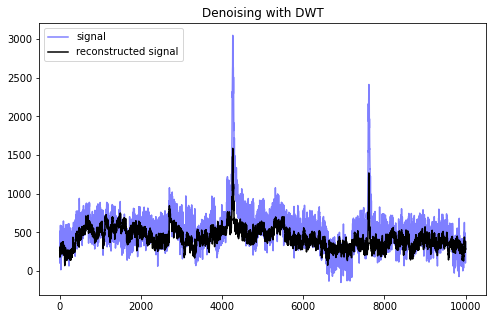

In [29]:
#signal=pd.read_csv('../raw_date/train/subj1_series1_data.csv')
#signal = signal.drop("id", axis=1)
#filtered = wavelet_denoising(signal, wavelet='db2', level=3)

#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(8,5))
#ax.plot(signal.iloc[:10000,1], label='signal', color="b", alpha=0.5,)
#ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
#ax.legend(loc='upper left')
#ax.set_title('Denoising with DWT')
#plt.show()

## Test splitting data

In [18]:
def custom_train_test_split(X, y):
     
    splitrate=-X.shape[0]//5*2
    xval=X[splitrate:splitrate//2]
    yval=y[splitrate:splitrate//2]
    xtest=X[splitrate//2:]
    ytest=y[splitrate//2:]
    xtrain=X[:splitrate]
    ytrain=y[:splitrate]
    
    return xtrain, xval, xtest, ytrain, yval, ytest 

In [19]:
# splitting the data 
xtrain, xval, xtest, ytrain, yval, ytest = custom_train_test_split(X, y)

In [20]:
xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape

((853434, 32),
 (284479, 32),
 (284479, 32),
 (853434, 6),
 (284479, 6),
 (284479, 6))

In [21]:
type(xtrain), type(xval), type(xtest), type(ytrain), type(yval), type(ytest)

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

## Scaling data

In [22]:
scaler= StandardScaler()
def data_scaler_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_scaler_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [23]:
X_train_scaled= data_scaler_train(xtrain)
X_val_scaled= data_scaler_test(xval)

In [24]:
X_train_scaled.shape, X_val_scaled.shape

((853434, 32), (284479, 32))

In [25]:
type(X_train_scaled), type(X_val_scaled)

(numpy.ndarray, numpy.ndarray)

## Generators

In [33]:
time_steps = 1000
subsample = 50

In [31]:
def generator(batch_size, xtrain, ytrain):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1],  x_time_data.shape[2],1)), yy

In [32]:
def valgenerator(xval, yval):
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2],1)), yy

# CNN Model 

In [36]:
load = 1

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(6, activation = "sigmoid"))


adam = Adam(lr = 0.0001)

model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 32, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 32, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0

In [37]:
es= EarlyStopping(patience=2)
history =model.fit_generator(generator(32,X_train_scaled,ytrain), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(X_val_scaled, yval),
                              validation_steps=200,callbacks=[es])

/Users/kenzamandri/.pyenv/versions/3.8.6/envs/Hand-Motions/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
600/600 [==============================] - 114s 188ms/step - loss: 0.6829 - accuracy: 0.2170 - mse: 0.2435 - val_loss: 0.5575 - val_accuracy: 0.1700 - val_mse: 0.1834
Epoch 2/50
 23/600 [>.............................] - ETA: 1:40 - loss: 0.5761 - accuracy: 0.2838 - mse: 0.1925

KeyboardInterrupt: 